# GraphSage

## Cora 数据集处理

In [1]:
from __future__ import print_function
import scipy.sparse as sp
import numpy as np
from collections import namedtuple

In [2]:
Data = namedtuple('Data', ['x', 'y', 'adjacency_dict', 'train_mask', 'val_mask', 'test_mask'])

In [3]:
class CoraData():
    def __init__(self, data_root='../../../data/cora/'):
        self._data_root = data_root
        self._data = self.process_data()
    
    def load_data(self, dataset='cora'):
        print('Loading {} dataset ...'.format(dataset))
        idx_features_labels = np.genfromtxt("{}{}.content".format(self._data_root, dataset), dtype=np.dtype(str))
        edges = np.genfromtxt("{}{}.cites".format(self._data_root, dataset), dtype=np.int32)
        return idx_features_labels, edges
    
    def process_data(self):
        
        print("Process data ...")

        idx_features_labels, edges = self.load_data()

        features = idx_features_labels[:, 1:-1].astype(np.float32)
        features = self.normalize_feature(features)

        y = idx_features_labels[:, -1]
        labels = self.encode_onehot(y)

        idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
        
        # print(edges.shape, edges[:3,:])

        for self_idx in idx:
            edges = np.vstack((edges, [self_idx, self_idx]))
            
        idx_map = {j: i for i, j in enumerate(idx)}
        edge_indexs = np.array(list(map(idx_map.get, edges.flatten())), dtype=np.int32)
        edge_indexs = edge_indexs.reshape(edges.shape)
        
        adjacency = {}
        for edge in edge_indexs:
            key = edge[0].astype(np.int32)
            value = edge[1].astype(np.int32)

            target_value = np.array([])
            if key in adjacency.keys():
                target_value = adjacency[key]

            target_value = np.append(target_value, value)

            adjacency.update({key : target_value})


        train_index = np.arange(150)
        val_index = np.arange(150, 500)
        test_index = np.arange(500, 2708)

        train_mask = np.zeros(edge_indexs.shape[0], dtype = np.bool)
        val_mask = np.zeros(edge_indexs.shape[0], dtype = np.bool)
        test_mask = np.zeros(edge_indexs.shape[0], dtype = np.bool)
        train_mask[train_index] = True
        val_mask[val_index] = True
        test_mask[test_index] = True
        #print(type(train_mask), train_mask.shape, train_mask)
        
        print('Dataset has {} nodes, {} edges, {} features'.format(features.shape[0], len(adjacency), features.shape[1]))
        return Data(x=features, y = labels, adjacency_dict=adjacency, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
    
    def encode_onehot(self, labels):
        classes = set(labels)
        classes_dict = {c:np.identity(len(classes))[i,:] for i,c in enumerate(classes)}
        labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
        return labels_onehot
    
    def normalize_adj(self, adjacency):
        """计算 L=D^-0.5 * (A+I) * D^-0.5"""
        adjacency += sp.eye(adjacency.shape[0])
        degreee = np.aray(adjacency.sum(1))
        d_hat = sp.diags(np.power(degree, -0.5).flatten())
        return d_hat.dot(adjacency).dot(d_hat).tocsr().todense()
    
    def normalize_feature(self, features):
        normal_feature = features / features.sum(1).reshape(-1,1)
        #print(normal_feature.shape, features.sum(1))
        return normal_feature
    
    def data(self):
        """返回Data数据对象，包括features, labes, adjacency, train_mask, val_mask, test_mask"""
        return self._data

In [4]:
data = CoraData().data()


Process data ...
Loading cora dataset ...
Dataset has 2708 nodes, 2708 edges, 1433 features


## 采样邻居
GNN模型中，图的信息聚合过程是沿着Graph Edge进行的，GNN中节点在第(k+1)层的特征只与其在(k)层的邻居有关，这种局部性质使得节点在(k)层的特征只与自己的k阶子图有关。因此对于k层网络，只需要采样Graph的k阶子图，就可以满足训练的需求。

同时为了提升运算效率，对每个顶点的邻居节点进行有放回的采样，保证每个节点邻居个数都是相同的。这也是神经网络中处理数据的一种常用的策

In [5]:
import numpy as np

def sampling(src_nodes, sample_num, neighbor_table):
    """根据源节点采样指定数量的邻居节点，注意使用的是有放回的采样；
    某个节点的邻居节点数量少于采样数量时，采样结果出现重复的节点
    
    Arguments:
        src_nodes {list, ndarray} -- 源节点列表
        sample_num {int} -- 需要采样的节点数
        neighbor_table {dict} -- 节点到其邻居节点的映射表
    
    Returns:
        np.ndarray -- 采样结果构成的列表
    """
    results = []
    for node in src_nodes:
        result = np.random.choice(neighbor_table[node], size = (sample_num,))
        results.append(result)
    return np.asarray(results).flatten()

def multihop_sampling(src_nodes, sample_nums, neighbor_table):
    """根据源节点进行多阶采样
    
    Arguments:
        src_nodes {list, np.ndarray} -- 源节点id
        sample_nums {list of int} -- 每一阶需要采样的个数
        neighbor_table {dict} -- 节点到其邻居节点的映射
    
    Returns:
        [list of ndarray] -- 每一阶采样的结果
    """
    #print('src_nodes', src_nodes.size)
    #print('sample_nums', sample_nums)
    #print('neighbor_table', len(neighbor_table))
    sampling_result = [src_nodes]
    for k, hopk_num in enumerate(sample_nums):
        hopk_result = sampling(sampling_result[k], hopk_num, neighbor_table)
        #print('hopk_result', len(hopk_result), hopk_result)
        sampling_result.append(hopk_result)
    return sampling_result

## 邻居节点聚合器

In [6]:
import tensorflow as tf

class NeighborAggregator(tf.keras.Model):
    def __init__(self,input_dim, output_dim,
                use_bias=False, aggr_method="mean"):
        """聚合节点邻居
        Args:
            input_dim: 输入特征的维度
            output_dim: 输出特征的维度
            use_bias: 是否使用偏置 (default: {False})
            aggr_method: 邻居聚合方式 (default: {mean})
        """
        super(NeighborAggregator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.aggr_method = aggr_method
        
        self.weight = self.add_weight(shape = (self.input_dim, self.output_dim),
                                     initializer = 'glorot_uniform', name = 'kernel')
        if self.use_bias:
            self.bias = self.add_weight(shape =(self.output_dim,),
                                       initializer = 'zero',
                                       name = 'bias')
            
    def call(self, neighbor_feature):
        if self.aggr_method == "mean":
            aggr_neighbor = tf.math.reduce_mean(neighbor_feature, axis = 1)
        elif self.aggr_method == "sum":
            aggr_neighbor = tf.math.reduce_sum(neighbor_feature, axis = 1)
        elif self.aggr_method == "max":
            aggr_neighbor = tf.math.reduce_max(neighbor_feature, axis = 1)
        else:
            raise ValueError("Unknown aggr type, expected sum, max, or mean, but got {}"
                             .format(self.aggr_method))
            
        neighbor_hidden = tf.matmul(aggr_neighbor, self.weight)
        if self.use_bias:
            #print('neigbor_hidden', neighbor_hidden.shape, 'bias', self.bias.shape)
            neighbor_hidden +=self.bias
        
        return neighbor_hidden
      

In [7]:
 NeighborAggregator(input_dim=1433, output_dim=128,use_bias=True, aggr_method="mean")


2022-07-20 18:35:41.309495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/lib/native/:/jre/lib/amd64/:/usr/local/lib64:/usr/local/lib:/usr/local/tensorflow/lib:/usr/local/mysql/lib:/usr/local/jdk/jre/lib/amd64/server:/usr/local/mkl/lib:/usr/local/hadoop/lib/native:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/lib/native/:/jre/lib/amd64/:/usr/local/lib64:/usr/local/lib:/usr/local/tensorflow/lib:/usr/local/mysql/lib:/usr/local/jdk/jre/lib/amd64/server:/usr/local/mkl/lib:/usr/local/hadoop/lib/native:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/lib/native/:/jre/lib/amd64/:/usr/local/lib64:/usr/local/lib:/usr/local/tensorflow/lib:/usr/local/mysql/lib:/usr/local/jdk/jre/lib/amd6

定义模型结构

In [8]:
class SageGCN(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim,
                activation = tf.keras.activations.relu,
                aggr_neighbor_method = "mean",
                aggr_hidden_method = "sum"):
        """SageGCN层定义
        Args:
            input_dim: 输入特征的维度
            hidden_dim: 隐层特征的维度，
                当aggr_hidden_method=sum, 输出维度为hidden_dim
                当aggr_hidden_method=concat, 输出维度为hidden_dim*2
            activation: 激活函数
            aggr_neighbor_method: 邻居特征聚合方法，["mean", "sum", "max"]
            aggr_hidden_method: 节点特征的更新方法，["sum", "concat"]
        """
        super(SageGCN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.aggr_neighbor_method = aggr_neighbor_method
        self.aggr_hidden_method = aggr_hidden_method
        self.activation = activation
        
        self.aggregator = NeighborAggregator(input_dim, hidden_dim, use_bias=True,aggr_method=aggr_neighbor_method)
        
        self.weight = self.add_weight(shape=(self.input_dim, self.hidden_dim),
                                     initializer = 'glorot_uniform',
                                     name = 'kernel')
        
    def call(self, src_node_features, neighbor_node_features):
        #print('src_node_features', (src_node_features).shape)
        #print('neighbor_node_features', (neighbor_node_features).shape)
        neighbor_hidden = self.aggregator(neighbor_node_features)
        self_hidden = tf.matmul(src_node_features, self.weight)
        
        if self.aggr_hidden_method == "sum":
            hidden = self_hidden + neighbor_hidden
        elif self.aggr_hidden_method == "concat":
            hidden = tf.concat(1, [self_hidden, neighbor_hidden])
        else:
            raise ValueError("Expected sum or concat, got {}"
                             .format(self.aggr_hidden_method))
        #print('hidden', hidden.shape)
        if self.activation:
            return self.activation(hidden)
        else:
            return hidden
    

class GraphSage(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim,
                 num_neighbors_list):

        super(GraphSage, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_neighbors_list = num_neighbors_list
        self.num_layers = len(num_neighbors_list)
        self.gcn = []
        self.gcn.append(SageGCN(input_dim, hidden_dim[0]))
        
        for index in range(0, len(hidden_dim) - 2):
            self.gcn.append(SageGCN(hidden_dim[index], hidden_dim[index + 1]))
        
        self.gcn.append(SageGCN(hidden_dim[-2], hidden_dim[-1], activation=None))

    def call(self, node_features_list):
        hidden = node_features_list
        #print('gcn len', len(self.gcn), self.num_layers, len(node_features_list))
        
        for l in range(self.num_layers):
            next_hidden = []
            gcn = self.gcn[l]
            for hop in range(self.num_layers - l):
                src_node_features = hidden[hop]
                src_node_num = len(src_node_features)
                #print('src_node_num',src_node_num, src_node_features.shape)
                neighbor_node_features = tf.reshape(hidden[hop + 1], (src_node_num, self.num_neighbors_list[hop], -1))
                #print('neighbor_node_features',neighbor_node_features.shape, hidden[hop + 1].shape,self.num_neighbors_list[hop] )
                h = gcn(src_node_features, neighbor_node_features)
                next_hidden.append(h)
            hidden = next_hidden
            #print('out_hidden', type(hidden), len(hidden), hidden[0].shape)
        #print('final_out_hidden', type(hidden), len(hidden), hidden[0].shape)
        return hidden[0]

## 模型训练


In [9]:
import matplotlib.pyplot as plt

INPUT_DIM = 1433 # 输入特征纬度
# Note: 采样的邻居阶数需要与GCN的层数保持一致
HIDDEM_DIM = [128, 7] # 隐藏单元节点数目
NUM_NEIGHBORS_LIST = [10,10] # 每阶采样，采样的邻居节点数

assert len(HIDDEM_DIM) == len(NUM_NEIGHBORS_LIST)
BTACH_SIZE = 16 # batchsize 大小
EPOCHS= 20
NUM_BATCH_PER_EPOCH = 20 # 每个epoch，循环的批次数
LEARNING_RATE = 0.01 # 学习率



In [10]:

model =GraphSage(input_dim = INPUT_DIM,
                hidden_dim = HIDDEM_DIM,
                num_neighbors_list = NUM_NEIGHBORS_LIST)
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, decay=5e-4)


train_index = np.where(data.train_mask)[0]
train_label = data.y[train_index]

test_index = np.where(data.test_mask)[0]
val_index = np.where(data.val_mask)[0]

# 记录过程，方便可视化
train_loss_results = []
train_accuracy_results = []
train_val_results = []
train_test_results = []

In [11]:
print(train_index.shape, train_index)
print(train_label.shape, train_label)

(150,) [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]
(150, 7) [[0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 0]]


In [12]:
def train():
    for e in range(EPOCHS):
        for batch in range(NUM_BATCH_PER_EPOCH):
            batch_src_index = np.random.choice(train_index, size=(BTACH_SIZE,))
            batch_src_label = train_label[batch_src_index].astype(float)

            batch_sampling_result = multihop_sampling(batch_src_index, NUM_NEIGHBORS_LIST, data.adjacency_dict)
            batch_sampling_x = [data.x[np.array(idx.astype(np.int32))] for idx in batch_sampling_result]
            #print('batch_sampling_result', type(batch_sampling_result), len(batch_sampling_result), batch_sampling_result[1].size)
            #print('batch_sampling_x', type(batch_sampling_x),  len(batch_sampling_x), batch_sampling_x[1].size)


            loss = 0.0
            with tf.GradientTape() as tape:
                batch_train_logits = model(batch_sampling_x)
                loss = loss_object(batch_src_label, batch_train_logits)
                grads = tape.gradient(loss, model.trainable_variables)

                optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # print("Epoch {:03d} Batch {:03d} Loss: {:.4f}".format(e, batch, loss))
        
        train_accuracy = test(train_index)
        val_accuracy = test(val_index)
        test_accuracy = test(test_index)

        train_loss_results.append(loss)
        train_accuracy_results.append(train_accuracy)
        train_val_results.append(val_accuracy)
        train_test_results.append(test_accuracy)

        print("Epoch {:03d} train accuracy: {} val accuracy: {} test accuracy:{}".format(e, train_accuracy, val_accuracy, test_accuracy))
        
        # ISSUE: https://stackoverflow.com/questions/58947679/no-gradients-provided-for-any-variable-in-tensorflow2-0

    # 训练过程可视化
    fig, axes = plt.subplots(4, sharex=True, figsize=(12, 8))
    fig.suptitle('Training Metrics')

    axes[0].set_ylabel("Loss", fontsize=14)
    axes[0].plot(train_loss_results)

    axes[1].set_ylabel("Accuracy", fontsize=14)
    axes[1].plot(train_accuracy_results)

    axes[2].set_ylabel("Val Acc", fontsize=14)
    axes[2].plot(train_val_results)

    axes[3].set_ylabel("Test Acc", fontsize=14)
    axes[3].plot(train_test_results)

    plt.show()

In [13]:
def test(index):
    test_sampling_result = multihop_sampling(index, NUM_NEIGHBORS_LIST, data.adjacency_dict)
    test_x = [data.x[idx.astype(np.int32)] for idx in test_sampling_result]
    test_logits = model(test_x)
    test_label = data.y[index]

    ll = tf.math.equal(tf.math.argmax(test_label, -1), tf.math.argmax(test_logits, -1))
    accuarcy = tf.reduce_mean(tf.cast(ll, dtype=tf.float32))

    return accuarcy

Epoch 000 train accuracy: 0.8399999737739563 val accuracy: 0.47428572177886963 test accuracy:0.35733696818351746
Epoch 001 train accuracy: 0.9666666388511658 val accuracy: 0.7142857313156128 test accuracy:0.6707427501678467
Epoch 002 train accuracy: 1.0 val accuracy: 0.6885714530944824 test accuracy:0.6435688138008118
Epoch 003 train accuracy: 1.0 val accuracy: 0.6828571557998657 test accuracy:0.6417572498321533
Epoch 004 train accuracy: 1.0 val accuracy: 0.6857143044471741 test accuracy:0.645380437374115
Epoch 005 train accuracy: 1.0 val accuracy: 0.7114285826683044 test accuracy:0.6698369383811951
Epoch 006 train accuracy: 1.0 val accuracy: 0.7114285826683044 test accuracy:0.6648550629615784
Epoch 007 train accuracy: 1.0 val accuracy: 0.7285714149475098 test accuracy:0.6603260636329651
Epoch 008 train accuracy: 1.0 val accuracy: 0.699999988079071 test accuracy:0.6648550629615784
Epoch 009 train accuracy: 1.0 val accuracy: 0.7142857313156128 test accuracy:0.6634963750839233
Epoch 010 

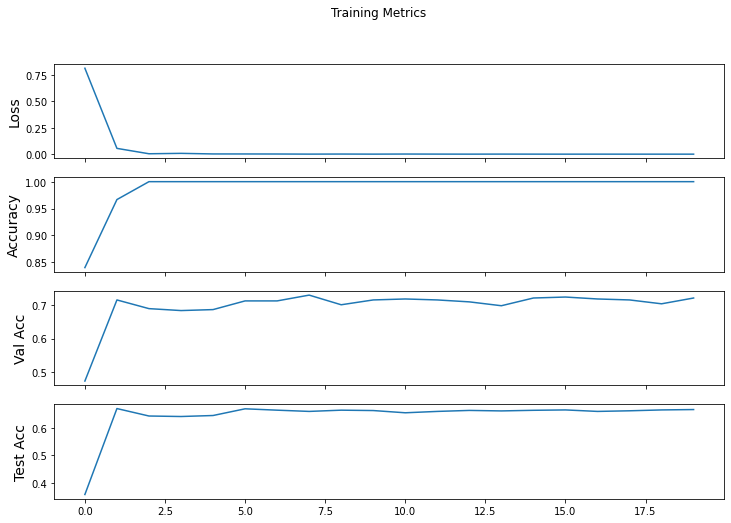

In [14]:
if __name__ == '__main__':
    train()